# Đếm và hiển thị tên file mp4

In [2]:
import os
import cv2
import numpy as np
import librosa
import soundfile as sf
import csv
import matplotlib.pyplot as plt

from scenedetect import VideoManager, SceneManager
from scenedetect.detectors import ContentDetector
from scenedetect.video_splitter import split_video_ffmpeg

d:\Projects\Python_Projects\LVTN_Search_Films_FAISS\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Đường dẫn đến thư mục cha
folder_path = r'E:\Data\Film_Dataset'  

# Lấy danh sách thư mục con
subfolders = [
    f for f in os.listdir(folder_path)
    if os.path.isdir(os.path.join(folder_path, f))
]

# In số lượng thư mục con
print(f"Số lượng thư mục con: {len(subfolders)}")

# In tên từng thư mục
for folder_name in subfolders:
    print(folder_name)

In [ ]:
movie_titles = [
    "Những Nụ Hôn Rực Rỡ", "Hoán Đổi", "Lật Mặt 1", "Giả Nghèo Gặp Phật", "Ăn Tết Bên Cồn",
    "Kẻ Ăn Hồn", "Oán Linh (Phần 1)", "Lộ Mặt", "21 Ngày Yêu Em", "Đào Phở Và Piano",
    "Kẻ Ẩn Danh", "Định Mệnh Thiên Ý", "Taxi Em Tên Gì", "Thiên Mệnh Anh Hùng", "Hẻm Cụt",
    "Chờ Em Đến Ngày Mai", "Ra Mắt Gia Tiên", "Em Chưa 18", "Siêu Quậy", "Cô Ba Sài Gòn",
    "Bẫy Ngọt Ngào", "Tiểu Thư Và Ba Đầu Gấu", "Bí Mật Lại Bị Mất", "Bí Mật Trong Sương Mù",
    "The Call", "Chuyện Tết", "Quý Cô Thừa Kế", "Địa Đạo", "Bộ Tứ Oan Gia",
    "Trên Bàn Nhậu Dưới Bàn Mưu", "Ma Da", "Pháp Sư Tập Sự", "Mắt Biếc", "Đất Phương Nam",
    "Chủ Tịch Giao Hàng", "Em Là Của Em", "Bệnh Viện Ma", "Siêu Trợ Lý",
    "Siêu Lừa Gặp Siêu Lầy", "Ông Ngoại Tuổi 30", "Gái Già Lắm Chiêu 3", "Làm Giàu Với Ma"
]

# Tạo thư mục cho từng tên phim
for title in movie_titles:
    safe_title = title.strip()
    full_path = os.path.join(folder_path, safe_title)
    os.makedirs(full_path, exist_ok=True)

print(f"Đã tạo {len(movie_titles)} thư mục tại: {folder_path}")

Đã tạo 42 thư mục tại: /path/to/folder


In [3]:
# Đường dẫn thư mục gốc chứa các folder con
base_path = r"E:\Data\Film_Dataset"  

# Danh sách lưu các folder không hợp lệ
invalid_folders = []

# Duyệt qua từng thư mục con
for folder_name in os.listdir(base_path):
    folder_path = os.path.join(base_path, folder_name)

    if os.path.isdir(folder_path):
        # Lấy danh sách file .mp4 trong thư mục con
        mp4_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.mp4')]

        if len(mp4_files) != 1:
            invalid_folders.append((folder_name, len(mp4_files)))

# Kết quả
if not invalid_folders:
    print("✅ Tất cả thư mục con đều chứa đúng 1 file .mp4.")
else:
    print("❌ Các thư mục sau không hợp lệ:")
    for name, count in invalid_folders:
        print(f"  - {name}: {count} file .mp4")

✅ Tất cả thư mục con đều chứa đúng 1 file .mp4.


# Cắt video ra thành từng đoạn video ngắn

### Cắt dựa trên màu sắc, âm thanh, số pixel, độ sáng

In [ ]:
# ==== Các hàm xử lý đặc trưng ====
def calculate_frame_difference(prev_frame, curr_frame, threshold=5000):
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)
    frame_diff = cv2.absdiff(prev_gray, curr_gray)
    return np.count_nonzero(frame_diff) > threshold

def average_color(frame):
    return np.mean(frame, axis=(0, 1))

def is_similar_color(c1, c2, threshold=30):
    return np.linalg.norm(c1 - c2) < threshold

def average_brightness(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    return np.mean(gray)

# ==== Xử lý âm thanh ====
def extract_audio_ffmpeg(video_path, audio_path="temp_audio.wav"):
    os.system(f"ffmpeg -y -i \"{video_path}\" -vn -acodec pcm_s16le -ar 22050 -ac 1 \"{audio_path}\"")

def get_audio_rms_librosa(audio_path, frame_count, fps):
    y, sr = librosa.load(audio_path, sr=None)
    hop_length = int(sr / fps)
    rms = librosa.feature.rms(y=y, frame_length=hop_length * 2, hop_length=hop_length)[0]
    return rms[:frame_count]

def add_audio_to_video(video_path, original_audio, output_path, start_time, duration):
    temp_audio = "segment_audio.wav"
    os.system(f"ffmpeg -y -i \"{original_audio}\" -ss {start_time:.2f} -t {duration:.2f} -acodec copy \"{temp_audio}\"")
    os.system(f"ffmpeg -y -i \"{video_path}\" -i \"{temp_audio}\" -c:v copy -c:a aac -strict experimental \"{output_path}\"")
    os.remove(video_path)
    os.remove(temp_audio)

# ==== Ghi đoạn video ra file ====
def save_segment(output_dir, frames, fps, width, height, seg_idx):
    filename = os.path.join(output_dir, f"segment_{seg_idx:03}.avi")
    out = cv2.VideoWriter(filename, cv2.VideoWriter_fourcc(*'XVID'), fps, (width, height))
    for f in frames:
        out.write(f)
    out.release()
    return filename

# ==== Ghi log vào CSV ====
def write_log_csv(csv_writer, video_name, seg_idx, start_time, duration, frame_start, frame_end):
    csv_writer.writerow({
        'video': video_name,
        'segment_id': seg_idx,
        'start_time': f"{start_time:.2f}",
        'duration': f"{duration:.2f}",
        'frame_start': frame_start,
        'frame_end': frame_end
    })

# ==== Cắt video ====
def cut_video_by_features(video_path, output_dir, csv_writer, color_thresh, audio_thresh, min_segment_length, motion_thresh, brightness_thresh):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"[Lỗi] Không mở được video: {video_path}")
        return 0

    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    video_name = os.path.basename(video_path)

    audio_path = "temp_audio.wav"
    extract_audio_ffmpeg(video_path, audio_path)
    audio_rms = get_audio_rms_librosa(audio_path, total_frames, fps)

    os.makedirs(output_dir, exist_ok=True)
    seg_idx = 0

    ret, prev_frame = cap.read()
    if not ret:
        cap.release()
        os.remove(audio_path)
        return 0

    segment_frames = [prev_frame]
    prev_color = average_color(prev_frame)
    prev_audio = audio_rms[0]
    prev_brightness = average_brightness(prev_frame)
    start_idx = 0
    current_idx = 1

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        curr_color = average_color(frame)
        curr_audio = audio_rms[current_idx] if current_idx < len(audio_rms) else 0
        curr_brightness = average_brightness(frame)

        color_changed = not is_similar_color(curr_color, prev_color, color_thresh)
        audio_changed = abs(curr_audio - prev_audio) > audio_thresh
        motion_detected = calculate_frame_difference(prev_frame, frame, motion_thresh)
        brightness_changed = abs(curr_brightness - prev_brightness) > brightness_thresh

        if color_changed and audio_changed and motion_detected and brightness_changed:
            if len(segment_frames) >= min_segment_length:
                segment_path = save_segment(output_dir, segment_frames, fps, width, height, seg_idx)
                duration = len(segment_frames) / fps
                start_time = start_idx / fps
                final_output = os.path.join(output_dir, f"segment_{seg_idx:03}_with_audio.mp4")
                add_audio_to_video(segment_path, audio_path, final_output, start_time, duration)
                write_log_csv(csv_writer, video_name, seg_idx, start_time, duration, start_idx, current_idx - 1)
                seg_idx += 1

            segment_frames = [frame]
            start_idx = current_idx
        else:
            segment_frames.append(frame)

        prev_frame = frame
        prev_color = curr_color
        prev_audio = curr_audio
        prev_brightness = curr_brightness
        current_idx += 1

    # Lưu đoạn cuối nếu còn lại
    if len(segment_frames) >= min_segment_length:
        segment_path = save_segment(output_dir, segment_frames, fps, width, height, seg_idx)
        duration = len(segment_frames) / fps
        start_time = start_idx / fps
        final_output = os.path.join(output_dir, f"segment_{seg_idx:03}_with_audio.mp4")
        add_audio_to_video(segment_path, audio_path, final_output, start_time, duration)
        write_log_csv(csv_writer, video_name, seg_idx, start_time, duration, start_idx, current_idx - 1)

    cap.release()
    os.remove(audio_path)
    return seg_idx + 1

# ==== Xử lý thư mục nhiều video ====
def process_folder_structure(input_root, output_root, log_csv_path, color_thresh, audio_thresh, min_segment_length, motion_thresh, brightness_thresh):
    with open(log_csv_path, mode='w', newline='', encoding='utf-8') as csv_file:
        csv_writer = csv.DictWriter(csv_file, fieldnames=["video", "segment_id", "start_time", "duration", "frame_start", "frame_end"])
        csv_writer.writeheader()

        for subfolder in os.listdir(input_root):
            sub_path = os.path.join(input_root, subfolder)
            if os.path.isdir(sub_path):
                mp4_files = [f for f in os.listdir(sub_path) if f.endswith(".mp4")]
                if not mp4_files:
                    print(f"[Bỏ qua] Không tìm thấy file .mp4 trong: {sub_path}")
                    continue

                video_path = os.path.join(sub_path, mp4_files[0])
                out_subdir = os.path.join(output_root, subfolder)
                print(f"🔍 Đang xử lý: {subfolder}")
                segment_count = cut_video_by_features(
                    video_path, out_subdir, csv_writer,
                    color_thresh, audio_thresh, min_segment_length, motion_thresh, brightness_thresh
                )
                print(f"✅ Đã xử lý {segment_count} đoạn trong {subfolder}\n")

# ==== Chạy chương trình chính ====
input_video_path = 'E:\\Data\\Film_Dataset'
output_video_path = 'E:\\Data\\Film_Cut_Dataset'
log_csv_path = 'segment_log.csv'

process_folder_structure(
    input_video_path,
    output_video_path,
    log_csv_path,
    color_thresh=50,
    audio_thresh=0.01,
    min_segment_length=10,
    motion_thresh=5000,
    brightness_thresh=5
)


### Cắt bẳng PySceneDetect

In [ ]:
# Hàm tách video bằng PySceneDetect và lưu vào thư mục tương ứng
def cut_video_with_pyscenedetect(video_path, output_dir, threshold=30.0, min_scene_length=15):
    # Tạo thư mục nếu chưa có
    os.makedirs(output_dir, exist_ok=True)

    # Tạo các đối tượng quản lý video và cảnh
    video_manager = VideoManager([video_path])
    scene_manager = SceneManager()
    scene_manager.add_detector(ContentDetector(threshold=threshold, min_scene_len=min_scene_length))

    # Khởi tạo xử lý video
    video_manager.set_downscale_factor()
    video_manager.start()
    scene_manager.detect_scenes(frame_source=video_manager)

    # Lấy danh sách các cảnh
    scene_list = scene_manager.get_scene_list()
    print(f"[INFO] {len(scene_list)} cảnh được phát hiện trong {os.path.basename(video_path)}.")

    if len(scene_list) == 0:
        print("⚠️ Không phát hiện cảnh nào.")
        return 0

    # Tách và lưu các cảnh thành file .mp4
    split_video_ffmpeg(
        video_path,
        scene_list,
        output_file_template=os.path.join(output_dir, "scene_$SCENE_NUMBER.mp4")
    )

    video_manager.release()
    return len(scene_list)

# Xử lý toàn bộ thư mục chứa video
def process_folder_structure_with_scenedetect(input_root, output_root, threshold=30.0, min_scene_length=15):
    for subfolder in os.listdir(input_root):  # Duyệt qua từng thư mục con trong input_root
        sub_path = os.path.join(input_root, subfolder)
        
        if os.path.isdir(sub_path):  # Chỉ xử lý thư mục
            # Tìm file .mp4 trong thư mục con
            mp4_files = [f for f in os.listdir(sub_path) if f.endswith(".mp4")]
            if not mp4_files:
                print(f"[Bỏ qua] Không tìm thấy file .mp4 trong: {sub_path}")
                continue

            # Lấy video đầu tiên trong thư mục con
            video_path = os.path.join(sub_path, mp4_files[0])

            # Tạo thư mục đầu ra tương ứng với thư mục con trong input_root
            out_subdir = os.path.join(output_root, subfolder)
            os.makedirs(out_subdir, exist_ok=True)

            print(f"🎬 Đang xử lý video: {video_path}")
            scene_count = cut_video_with_pyscenedetect(video_path, out_subdir, threshold, min_scene_length)
            print(f"✅ Đã tách {scene_count} cảnh và lưu vào: {out_subdir}\n")

# Đường dẫn vào/ra
input_video_path = 'E:\\Data\\Film_Dataset'
output_video_path = 'E:\\Data\\Film_Cut_Dataset'

# Gọi hàm chính
process_folder_structure_with_scenedetect(input_video_path, output_video_path, threshold=60.0, min_scene_length=20)


# Trực quan dữ liệu

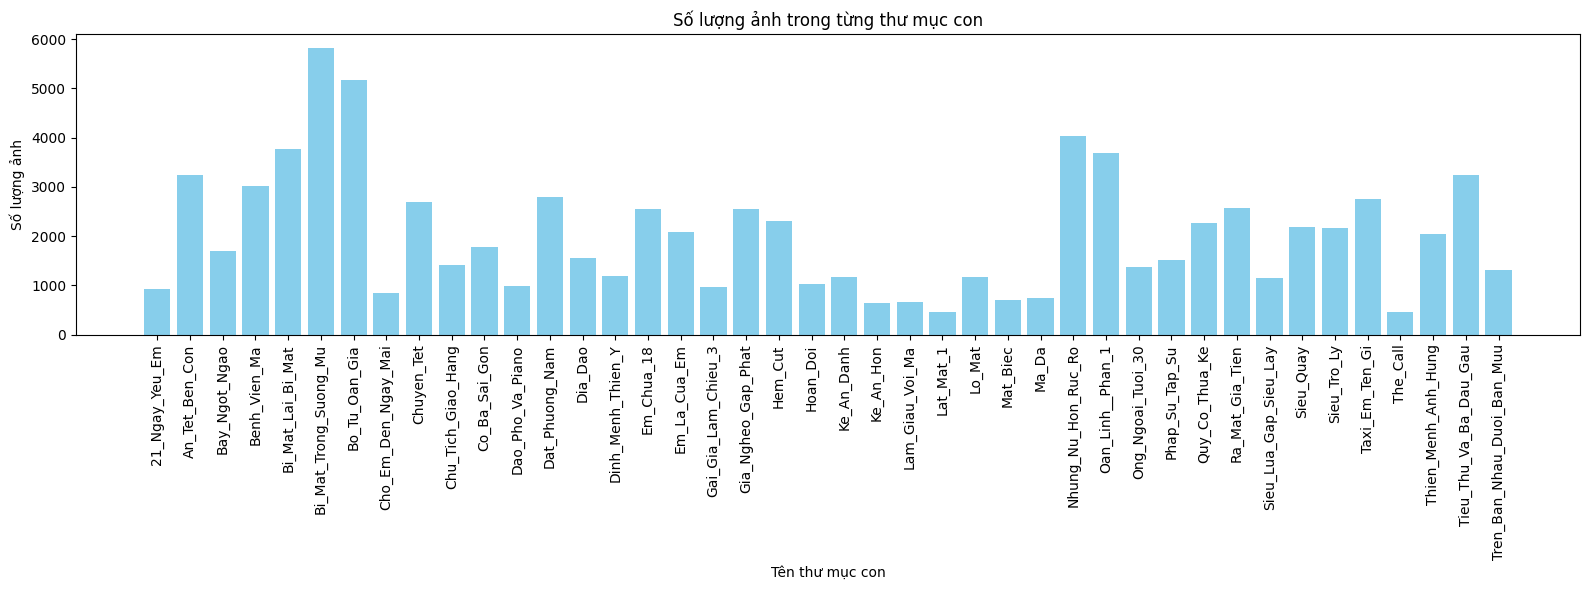

In [ ]:
def count_images_per_folder(root_dir, image_extensions=None):
    if image_extensions is None:
        image_extensions = ['.jpg']

    folder_counts = {}
    for subdir, dirs, files in os.walk(root_dir):
        if subdir == root_dir:
            continue  # bỏ qua thư mục gốc
        count = sum(1 for file in files if any(file.lower().endswith(ext) for ext in image_extensions))
        if count > 0:
            folder_name = os.path.basename(subdir)
            folder_counts[folder_name] = count

    return folder_counts

def plot_image_counts(folder_counts):
    folders = list(folder_counts.keys())
    counts = list(folder_counts.values())

    plt.figure(figsize=(16, 6))
    plt.bar(folders, counts, color='skyblue')
    plt.xticks(rotation=90)
    plt.xlabel('Tên thư mục con')
    plt.ylabel('Số lượng ảnh')
    plt.title('Số lượng ảnh trong từng thư mục con')
    plt.tight_layout()
    plt.show()

folder_train_path = 'E:\\Data\\Frame_Train_Dataset'
counts = count_images_per_folder(folder_train_path)
plot_image_counts(counts)


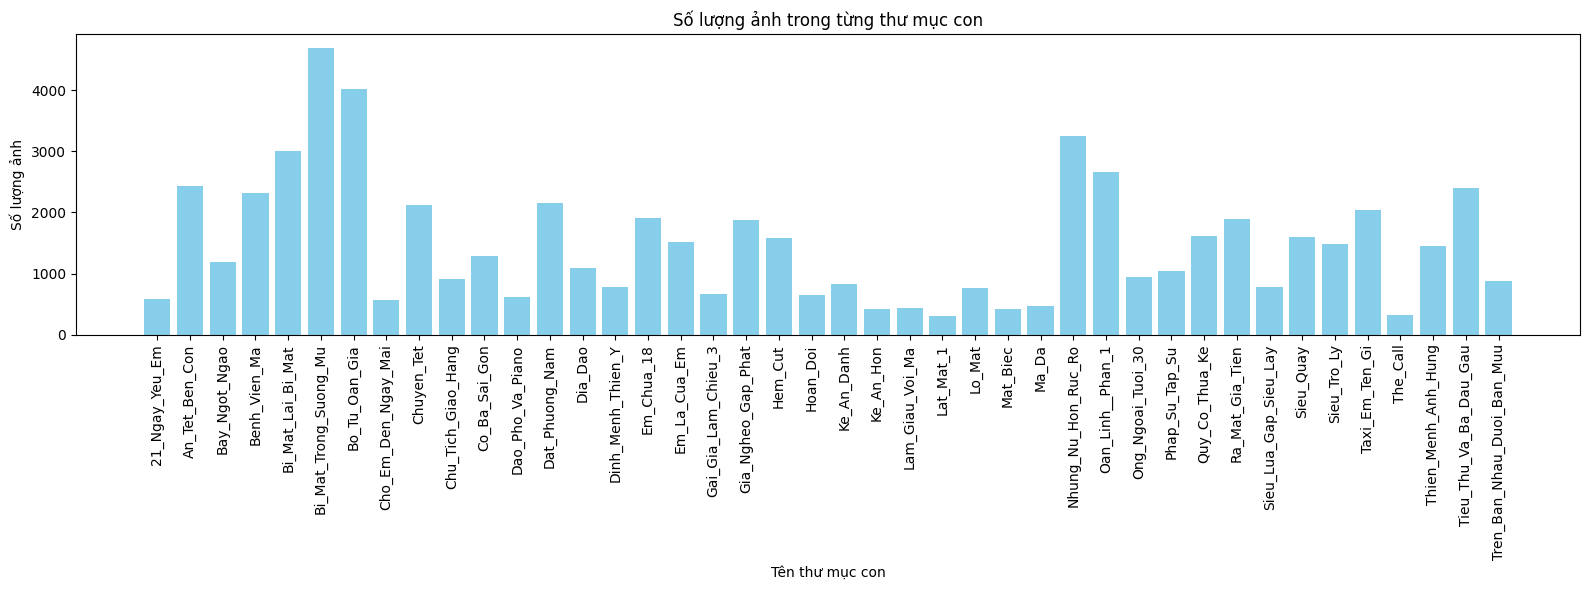

In [3]:
folder_test_path = 'E:\\Data\\Frame_Test_Dataset'
counts = count_images_per_folder(folder_test_path)
plot_image_counts(counts)